# GEO3463: RE5 and RE8 Light attenuation code (Sensing Secchi Disk) for SAMS field trip Day 1 (14/05/24)

## Load programmes

In [1]:
#Programes and functions
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
from matplotlib import ticker

###Define function for diffuse attenuation coefficient
def fcn2min_Kds(params1, X1, Y1):
        G1 = params1['G1']
        KD = params1['KD']
        model = G1+(-KD*X1)
        return(model-Y1)

### Supress warnings (prevents Jupyter printing out warnings....do be careful with this)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read Creran data

In [3]:
### Sensing Secchi disk
File_1= ['240516_A005_LL_0902UTC_LY01.txt',\
         '240516_A005_LL_0935UTC_LY02.txt',\
         '240516_A005_LL_1003UTC_LY04.txt',\
         '240516_A005_LL_1024UTC_CYLL.txt',\
         '240516_A005_LL_1043UTC_C01.txt',\
         '240516_A005_LL_1103UTC_C02.txt',\
         '240516_A005_LL_1151UTC_C03.txt',\
         '240516_A005_LL_1214UTC_C04.txt',\
         '240516_A005_LL_1229UTC_C05.txt',\
         '240516_A005_LL_1247UTC_C06.txt']

INDEX_FILE = ['LY1','LY2','LY4','CYLL','C1','C2','C3','C4','C5','C6']

#Deployment lowing speed
SPEED_LOW = np.empty(len(File_1))

Wavelength = [415,445,480,515,555,590,630,680]

CNT = 1
for i in range(len(File_1)):
    df = pd.read_csv(""+File_1[i], header = 7)
    Time_SS           = df.loc[:,'Millisecond since start'].to_numpy()
    Pressure_SS       = df.loc[:,' Pressure (mbar) MS5803'].to_numpy()
    Temp_MS5803_SS    = df.loc[:,' Temp (deg C) MS5803'].to_numpy()
    E415nm_SS         = df.loc[:,' 415nm'].to_numpy()
    E445nm_SS         = df.loc[:,' 445nm'].to_numpy()
    E480nm_SS         = df.loc[:,' 480nm'].to_numpy()
    E515nm_SS         = df.loc[:,' 515nm'].to_numpy()
    E555nm_SS         = df.loc[:,' 555nm'].to_numpy()
    E590nm_SS         = df.loc[:,' 590nm'].to_numpy()
    E630nm_SS         = df.loc[:,' 630nm'].to_numpy()
    E680nm_SS         = df.loc[:,' 680nm'].to_numpy()
    EPARnm_SS         = df.loc[:,' Clear'].to_numpy()
    ENIRnm_SS         = df.loc[:,' NIR'].to_numpy()
    ATMOS_P           = np.median(Pressure_SS[0:5]) ## Assume first 5 readings (5 Sec is atmos pressure)
    Depth_SS          = ((Pressure_SS - ATMOS_P)/100.) #0.02 remove for light 
    Depth_SS_L        = Depth_SS - 0.00  #Correct for distance between sensor and pressure (same for A004)
    DATA_SEC          = (Time_SS/1000.) + ((22*3600)+(19*60)+0) ##Time A004 was lanuched
    
    #Process to extract downcast based on gradient of depth
    asd = np.where(Depth_SS >= 0.5)
    
    #Extract Profile DATA
    Time_SS        = Time_SS[asd]
    Pressure_SS    = Pressure_SS[asd]
    Temp_MS5803_SS = Temp_MS5803_SS[asd]
    E415nm_SS      = E415nm_SS[asd]
    E445nm_SS      = E445nm_SS[asd]
    E480nm_SS      = E480nm_SS[asd]
    E515nm_SS      = E515nm_SS[asd]
    E555nm_SS      = E555nm_SS[asd]
    E590nm_SS      = E590nm_SS[asd]
    E630nm_SS      = E630nm_SS[asd]
    E680nm_SS      = E680nm_SS[asd]
    EPARnm_SS      = EPARnm_SS[asd]
    ENIRnm_SS      = ENIRnm_SS[asd]
    Depth_SS       = Depth_SS[asd]
    Depth_SS_L     = Depth_SS_L[asd]
    DATA_SEC       = DATA_SEC[asd]
    
    #Define array to put model parameters in
    G1_spect      = np.empty([len(Wavelength)])
    KD_spect      = np.empty([len(Wavelength)])
    G1_spect_SE   = np.empty([len(Wavelength)])
    KD_spect_SE   = np.empty([len(Wavelength)])
    G1_spect_BS   = np.empty([len(Wavelength)])
    KD_spect_BS   = np.empty([len(Wavelength)]) 
    G1_spect_BS_SE= np.empty([len(Wavelength)])
    KD_spect_BS_SE= np.empty([len(Wavelength)])
    
    #Fitting Kd
    for k in range(len(Wavelength)):
        if k == 0:
            Y = E415nm_SS
        if k == 1: 
            Y = E445nm_SS
        if k == 2: 
            Y = E480nm_SS
        if k == 3: 
            Y = E515nm_SS
        if k == 4: 
            Y = E555nm_SS
        if k == 5: 
            Y = E590nm_SS
        if k == 6: 
            Y = E630nm_SS
        if k == 7: 
            Y = E680nm_SS
        if k == 8:
            Y = EPARnm_SS

        #Fit above Secchi
        X     = Depth_SS_L
        XX    = X
        YY    = np.log(Y)

        #Linear regression 
        model = LinearRegression().fit(XX.reshape(-1, 1), YY.reshape(-1, 1))
        y = pd.DataFrame(YY)
        x = pd.DataFrame(XX, columns=['Y']) 
        #Standard error on slope
        N = len(x)
        p = len(x.columns) + 1  # plus one because LinearRegression adds an intercept term
        X_with_intercept = np.empty(shape=(N, p), dtype=float)
        X_with_intercept[:, 0] = 1
        X_with_intercept[:, 1:p] = x.values
        beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
        y_hat = model.predict(x)
        residuals = y.values - y_hat
        residual_sum_of_squares = residuals.T @ residuals
        sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
        var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
        standard_errors = np.empty(2)
        for p_ in range(p):
            standard_errors[p_] = var_beta_hat[p_, p_] ** 0.5
        G1_spect[k] =  float(model.intercept_)
        KD_spect[k] = float(model.coef_)*(-1) ###show kd non negative
        G1_spect_SE[k] = standard_errors[0] 
        KD_spect_SE[k] = standard_errors[1]     

    
    exec('Time_SS_'+INDEX_FILE[i]+'=Time_SS')
    exec('E415nm_SS_'+INDEX_FILE[i]+'=E415nm_SS')
    exec('E445nm_SS_'+INDEX_FILE[i]+'=E445nm_SS')
    exec('E480nm_SS_'+INDEX_FILE[i]+'=E480nm_SS')
    exec('E515nm_SS_'+INDEX_FILE[i]+'=E515nm_SS')
    exec('E555nm_SS_'+INDEX_FILE[i]+'=E555nm_SS')
    exec('E590nm_SS_'+INDEX_FILE[i]+'=E590nm_SS')
    exec('E630nm_SS_'+INDEX_FILE[i]+'=E630nm_SS')
    exec('E680nm_SS_'+INDEX_FILE[i]+'=E680nm_SS')   
    exec('EPARnm_SS_'+INDEX_FILE[i]+'=EPARnm_SS')   
    exec('ENIRnm_SS_'+INDEX_FILE[i]+'=ENIRnm_SS') 
    exec('Depth_SS_'+INDEX_FILE[i]+'=Depth_SS')  
    exec('Depth_SS_L_'+INDEX_FILE[i]+'=Depth_SS_L') 
    exec('G1_spect_'+INDEX_FILE[i]+'=G1_spect') 
    exec('KD_spect_'+INDEX_FILE[i]+'=KD_spect') 
 

## Plot diffuse attenution spectra

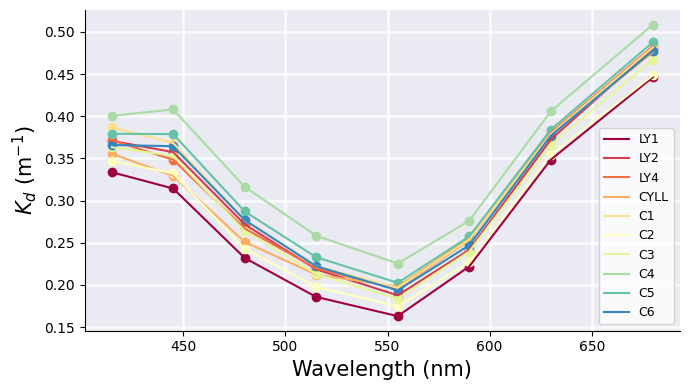

In [4]:
#Histograms
fig, (ax1) = plt.subplots(1,1, figsize=(7,4))

cmap = mpl.cm.get_cmap('Spectral')

LEN_F = float(len(File_1))
CNT = 0
for i in range(len(File_1)):
    #Sort data
    exec('KD_spect = KD_spect_'+INDEX_FILE[i]+'') 
 
    #plot 1   
    ax1.plot(Wavelength,KD_spect,color = cmap(CNT/LEN_F), label = ''+INDEX_FILE[i]+'')
    ax1.scatter(Wavelength,KD_spect,color = cmap(CNT/LEN_F), marker = 'o')
    ax1.set_xlabel('Wavelength (nm)', fontsize=15)  
    ax1.set_ylabel('$K_d$ (m$^{-1}$)', fontsize=15)
    ax1.set_facecolor('#eaeaf2')
    ax1.grid(color = 'white', alpha=0.75, linewidth = 2)
    ax1.set_axisbelow(True)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.legend(fontsize=9)
    CNT = CNT + 1.
    
plt.tight_layout()
plt.show()


## Read in Secchi depth and Forel Ule data

In [12]:
INDEX_FILE = ['LY0','LY1','LY2','LY4','CYLL','C1','C2','C3','C4','C5','C6']

## Secchi Depth and Forel Ule data (from Secchi_depth_Forel_Ule_Creran.csv)
Secchi_Depth        = [5.733333333,5.725,5.2325,5.2,5.433333333,5.2,\
                       5.633333333,4.475,6.163333333,5.966666667,5.2625]
Secchi_Depth_SDV    = [0.585946528,0.262995564,0.274271763,0.374165739,\
                       0.503322296,0.374165739,0.2081666,0.981070844,0.055075705,\
                       0.404145188,0.303795436]
Forel_Ule           = [11,11.25,12.25,11.5,12.66666667,12.25,10.66666667,12.25,11.33333333,\
                       11.66666667,13.25]
Forel_Ule_SDV       = [2.645751311,2.061552813,1.5,1.732050808,1.154700538,0.5,0.577350269,2.061552813,\
                       1.527525232,1.154700538,0.5]
Kd_555              = [np.nan,KD_spect_LY1[4],KD_spect_LY2[4],KD_spect_LY4[4],\
                       KD_spect_CYLL[4],KD_spect_C1[4],KD_spect_C2[4],KD_spect_C3[4],KD_spect_C4[4],\
                       KD_spect_C5[4],KD_spect_C6[4]]
Longitude           = [-5.50935,-5.5034,-5.466166667,-5.435516667,-5.404333333,-5.397366667, \
                       -5.383166667,-5.374333333,-5.347633333,-5.330066667,-5.30295]           

## Plot Secchi depth and Forel Ule data and Kd

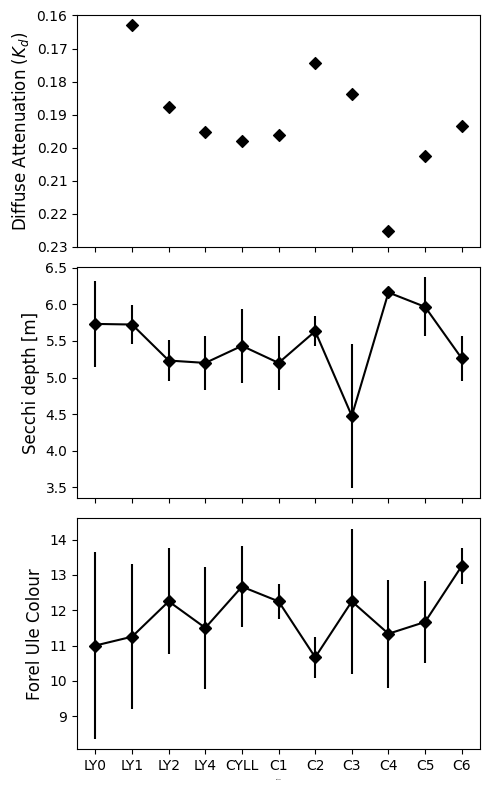

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5,8), sharex=True)

ax1.scatter(INDEX_FILE, Kd_555, c = 'k', marker = 'D')
ax1.set_ylabel('Diffuse Attenuation ($K_d$)', fontsize=12)
ax1.set_ylim([0.23,0.16])

ax2.errorbar(INDEX_FILE, Secchi_Depth, Secchi_Depth_SDV, c = 'k', marker = 'D')
ax2.set_ylabel('Secchi depth [m]', fontsize=12)

ax3.errorbar(INDEX_FILE, Forel_Ule, Forel_Ule_SDV, c = 'k', marker = 'D')
ax3.set_ylabel('Forel Ule Colour', fontsize=12)
ax3.set_xlabel('Stations', fontsize=1)

plt.tight_layout()
plt.show()